In [91]:
import torch
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [92]:
trans = transforms.Compose([
    transforms.ToTensor(),  #it is like numpy array for pytorch  
    transforms.Normalize((0.5,), (0.5,))  #this normalizes the data between -1 and 1
])
#download the data
train_data = datasets.MNIST(
    root="./data",
    train=True,
    transform=trans,
)
test_data = datasets.MNIST(
    root="./data",
    transform=trans,
    train=False,
)
#print the length of the data
print(len(train_data))
print(len(test_data))


60000
10000


In [93]:
#split the data into train and validation using sklearn
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data.targets)
print(len(train_data))
print(len(val_data))

48000
12000


In [94]:
#load the data using dataloader
#what does data loder do?it loads the data in batches-it shuffles the data-it makes the data iterable
#what is the batch size?it is the number of samples that will be passed through the network at once
#what is shuffle?it shuffles the data so that the model will not learn the order of the data
batch_sz = 16
train_loader = DataLoader(train_data, batch_size=batch_sz, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_sz, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_sz, shuffle=True)

In [95]:
print(len(train_loader))
#750 is the number of batches it came from 48000(the length of the train dataset)/64=750 
print(len(val_loader))
#188 is the number of batches it came from 12000(the length of the validation dataset)/64=188
print(len(test_loader))
#157 is the number of batches it came from 10000(the length of the test dataset)/64=157

3000
750
625


In [96]:
import torch.nn as n
import torch.nn.functional as f
from torch import optim

In [97]:
class neural_model(n.Module):
    def __init__(self):
        super().__init__()
        self.layers = n.Sequential(
            n.Flatten(),
            n.Linear(28 * 28, 200),#input layer=28*28=784 output layer=200
            n.Softplus(),
            n.Linear(200, 100),#input layer=200 output layer=100
            n.Softplus(),
            n.Linear(100, 10),#input layer=100 output layer=10
             n.LogSoftmax(dim=1)
        )
        self.loss = n.CrossEntropyLoss()
        self.learning_rate = 0.01
        self.optimizer = optim.SGD(self.parameters(), lr=self.learning_rate)

    def forward(self, x):
        x = self.layers(x)
        return x

    def fit(self, x, y):
        self.optimizer.zero_grad()  #this is to reset the gradients to zero
        y_pred = self.forward(x)  #this is to get the predictions
        loss = self.loss(y_pred, y)  #this is to get the loss
        loss.backward()  #this is to backpropagate the loss
        self.optimizer.step()  #this is to update the weights
        return loss.item()  #this is to return the loss
    def predict(self, x):
        y_pred = torch.argmax(self.forward(x))
        return y_pred


In [98]:
model = neural_model()

In [99]:
#train the model
epochs = 5
train_losses = []
val_losses = []
train_acc = []
val_acc = []
for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    train_accuracy = 0
    val_accuracy = 0
    for x, y in train_loader:
        train_loss += model.fit(x, y)
    train_losses.append(train_loss / len(train_loader))
    for x, y in val_loader:
        val_loss += model.fit(x, y)
    val_losses.append(val_loss / len(val_loader))
    
    # print(f"Epoch {epoch+1}/{epochs} train loss: {train_loss / len(train_loader)}")    


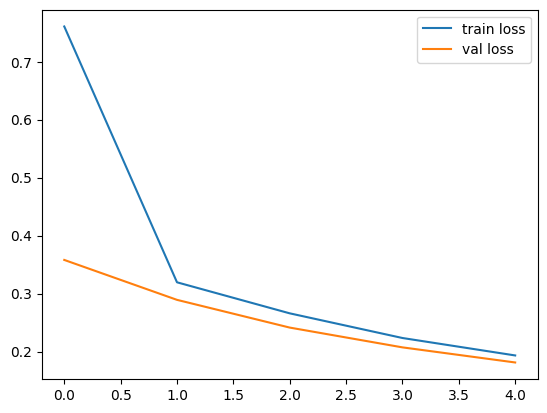

In [100]:
#plot the losses
import matplotlib.pyplot as plt
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.legend()
plt.show()

In [100]:
#get the accuracy and plot it
for x,y in train_loader:
    y_pred = model.predict(x)
